In [35]:
# Deleting all current variables
rm(list=ls())

# Ensuring consistent random values in the bookdown version (this can be ignored).
set.seed(2, kind = "Mersenne-Twister", normal.kind = "Inversion", sample.kind = "Rejection")

# Introduction to Machine Learning {#intro-ml}

RMD source: [link](https://docs.google.com/uc?export=download&id=110N1b5MYNXcIFZqWPqLbpqmgIkoMFqaF)

In this chapter, we’ll briefly review machine learning concepts that will be relevant later. We’ll focus in particular on the problem of **prediction**, that is, to model some output variable as a function of observed input covariates.

In [36]:
# loading relevant packages
# if you need to install a new package, 
# use e.g., install.packages("grf")
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(lmtest)
library(MASS)
library(sandwich)
library(ggplot2)
library(reshape2)

In this section, we will use simulated data. In the next section we'll load a real dataset.

In [37]:
# Simulating data

# Sample size
n <- 500

# Generating covariate X ~ Unif[-4, 4]
x <- runif(n, -4, 4)

# Generate outcome
# if x < 0:
#   y = cos(2*x) + N(0, 1)
# else:
#   y = 1-sin(x) + N(0, 1)
mu <- ifelse(x < 0, cos(2*x), 1-sin(x)) 
y <- mu + 1 * rnorm(n)

# collecting observations in a data.frame object
data <- data.frame(x=x, y=y)

# outcome variable name
outcome <- "y"

# covariate names
covariates <- c("x")

The following shows how the two variables `x` and `y` relate. Note that the relationship is nonlinear.

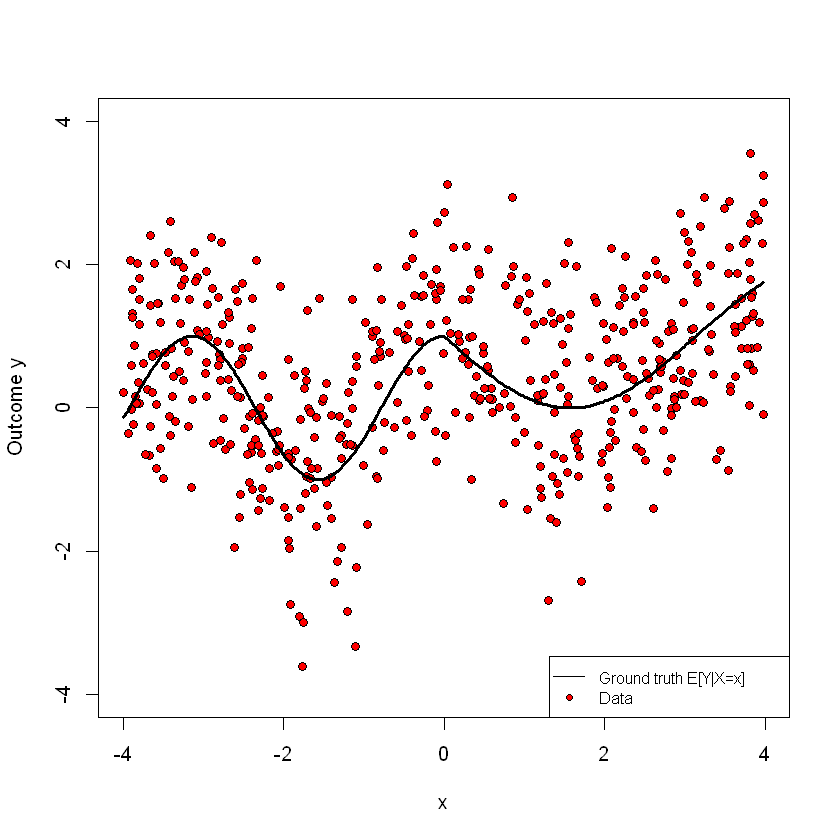

In [38]:
plot(x, y, col="black", ylim=c(-4, 4), pch=21, bg="red", ylab = "Outcome y")
lines(x[order(x)], mu[order(x)], col="black", lwd=3, type="l")
legend("bottomright", legend=c("Ground truth E[Y|X=x]", "Data"), cex=.8, lty=c(1, NA), col="black",  pch=c(NA, 21), pt.bg=c(NA, "red"))

Note: If you’d like to run the code below on a different dataset, you can replace the dataset above with another `data.frame` of your choice, and redefine the key variable identifiers (`outcome`, `covariates`) accordingly. Although we try to make the code as general as possible, you may also need to make a few minor changes to the code below; read the comments carefully.

## 1.1 Key concepts


The prediction problem is to accurately guess the value of some output variable $Y_i$ from input variables $X_i$. For example, we might want to predict “house prices given house characteristics such as the number of rooms, age of the building, and so on. The relationship between input and output is modeled in very general terms by some function
$$
(\#eq: true-model) 
  Y_i = f(X_i) + \epsilon_i
$$ (true-model)

where $\epsilon_i$ represents all that is not captured by information obtained from $X_i$ via the mapping $f$. We say that error $\epsilon_i$ is irreducible.

We highlight that  {eq}`true-model` is **not modeling a causal relationship** between inputs and outputs. For an extreme example, consider taking $Y_i$ to be “distance from the equator” and $X_i$ to be “average temperature.” We can still think of the problem of guessing (“predicting”) “distance from the equator” given some information about “average temperature,” even though one would expect the former to cause the latter.

In general, we can’t know the “ground truth”  $f$, so we will approximate it from data. Given $n$ data points $\{(X_1, Y_1), \cdots, (X_n, Y_n)\}$, our goal is to obtain an estimated model  $\hat{f}$ such that our predictions $\widehat{Y}_i := \hat{f}(X_i)$ are “close” to the true outcome values $Y_i$ given some criterion. To formalize this, we’ll follow these three steps:

+ **Modeling:** Decide on some suitable class of functions that our estimated model may belong to. In machine learning applications the class of functions can be very large and complex (e.g., deep decision trees, forests, high-dimensional linear models, etc). Also, we must decide on a loss function that serves as our criterion to evaluate the quality of our predictions (e.g., mean-squared error).

+ **Fitting:** Find the estimate $\hat{f}$ that optimizes the loss function chosen in the previous step (e.g., the tree that minimizes the squared deviation between $\hat{f}(X_i)$ and $Y_i$ in our data).

+ **Evaluation:** Evaluate our fitted model $\hat{f}$. That is, if we were given a new, yet unseen, input and output pair $(X',Y')$, we'd like to know if $Y' \approx \hat{f}(X_i)$ by some metric.

For concreteness, let’s work through an example. Let’s say that, given the data simulated above, we’d like to predict $Y_i$ from the first covariate  $X_{i1}$ only. Also, let’s say that our model class will be polynomials of degree $q$ in $X_{i1}$, and we’ll evaluate fit based on mean squared error. That is, $\hat{f}(X_{i1}) = \hat{b}_0 + X_{i1}\hat{b}_1 + \cdots + X_{i1}^q \hat{b}_q$, where the coefficients are obtained by solving the following problem:
$$
  \hat{b} = \arg\min_b \sum_{i=1}^m
    \left(Y_i - b_0 - X_{i1}b_1 - \cdots - X_{iq}^q b_q \right)^2
$$
An important question is what is $q$, the degree of the polynomial. It controls the complexity of the model. One may imagine that more complex models are better, but that is not always true, because a very flexible model may try to simply interpolate over the data at hand, but fail to generalize well for new data points. We call this **overfitting**. The main feature of overfitting is **high variance**, in the sense that, if we were given a different data set of the same size, we'd likely get a very different model.

To illustrate, in the figure below we let the degree be  $q=10$ but use only the first few data points. The fitted model is shown in green, and the original data points are in red.

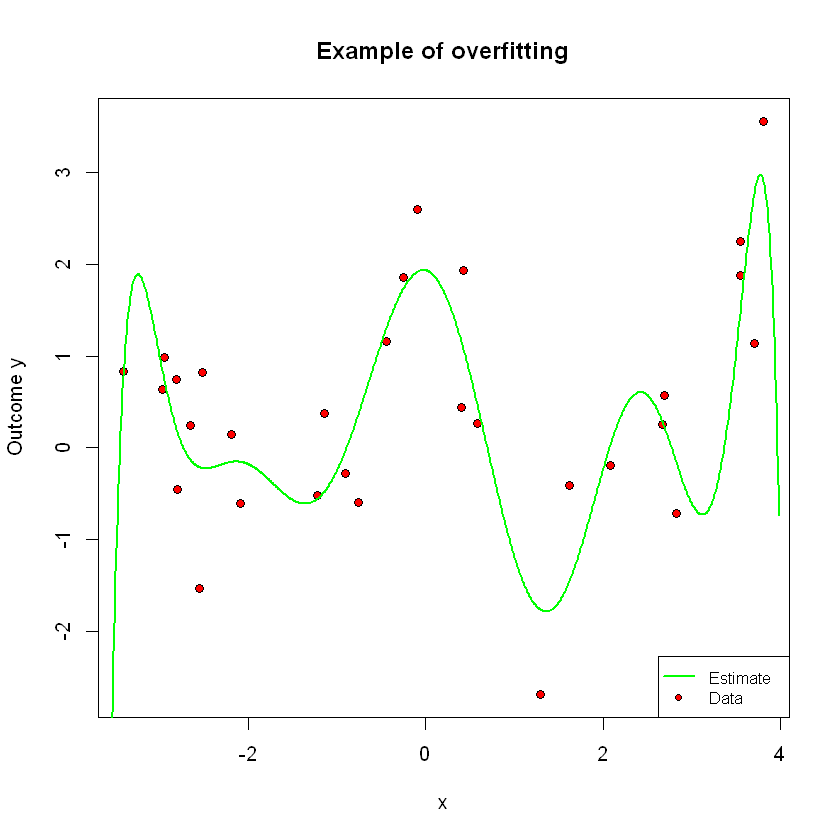

In [39]:
# Note: this code assumes that the first covariate is continuous.
# Fitting a flexible model on very little data

# selecting only a few data points
subset <- 1:30

# formula for a high-dimensional polynomial regression
# y ~ 1 + x1 + x1^2 + x1^3 + .... + x1^q
fmla <- formula(paste0(outcome, "~ poly(", covariates[1], ", 10)"))

# linear regression using only a few observations
ols <- lm(fmla, data = data, subset=subset)

# compute a grid of x1 values we'll use for prediction
x <- data[,covariates[1]]
x.grid <- seq(min(x), max(x), length.out=1000)
new.data <- data.frame(x.grid)
colnames(new.data) <- covariates[1]

# predict
y.hat <- predict(ols, newdata = new.data)

# plotting observations (in red) and model predictions (in green)
plot(data[subset, covariates[1]], data[subset, outcome], pch=21, bg="red", xlab=covariates[1], ylab="Outcome y", main="Example of overfitting")
lines(x.grid, y.hat, col="green", lwd=2, ylim=c(-3, 3))
legend("bottomright", legend=c("Estimate", "Data"), col = c("green", "black"),pch = c(NA, 21), pt.bg = c(NA, "red"), lty = c(1, NA), lwd = c(2, NA),cex = .8)

On the other hand, when $q$ is too small relative to our data, we permit only very simple models and may suffer from misspecification bias. We call this **underfitting**. The main feature of underfitting is **high bias** -- the selected model just isn't complex enough to accurately capture the relationship between input and output variables.

To illustrate underfitting, in the figure below we set $q=1$ (a linear fit).

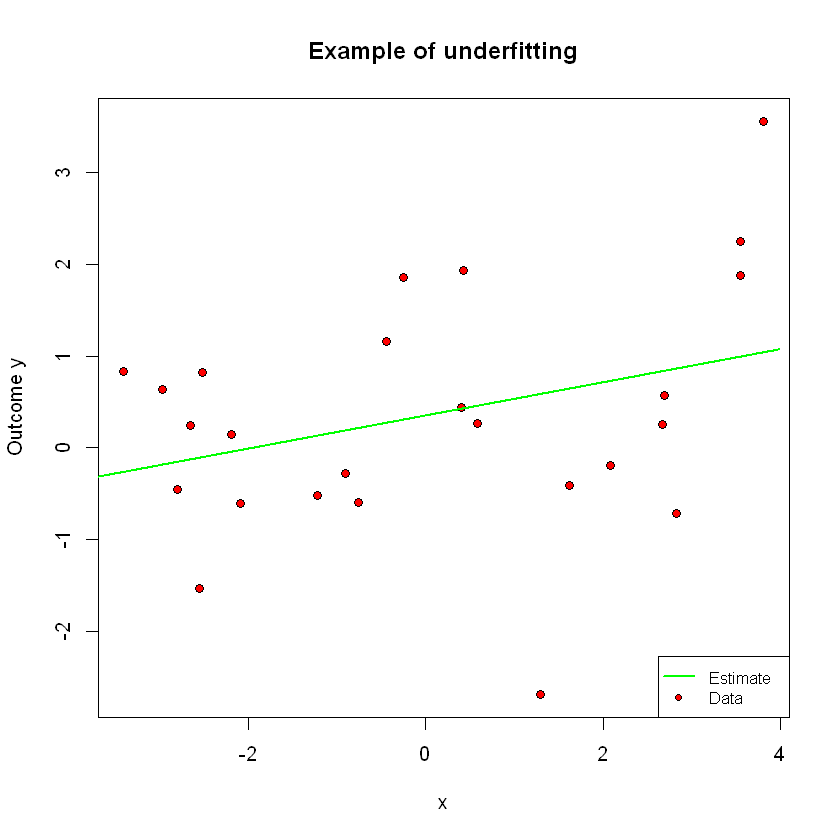

In [40]:
# Note: this code assumes that the first covariate is continuous
# Fitting a very simply model on very little data

# only a few data points
subset <- 1:25

# formula for a linear regression (without taking polynomials of x1)
# y ~ 1 + x1
fmla <- formula(paste0(outcome, "~", covariates[1]))

# linear regression
ols <- lm(fmla, data[subset,])

# compute a grid of x1 values we'll use for prediction
x <- data[,covariates[1]]
x.grid <- seq(min(x), max(x), length.out=1000)
new.data <- data.frame(x.grid)
colnames(new.data) <- covariates[1]

# predict
y.hat <- predict(ols, newdata = new.data)

# plotting observations (in red) and model predictions (in green)
plot(data[subset, covariates[1]], data[subset, outcome], pch=21, bg="red", xlab=covariates[1], ylab="Outcome y", main="Example of underfitting")
lines(x.grid, y.hat, col="green", lwd=2)
legend("bottomright", legend=c("Estimate", "Data"), col = c("green", "black"),pch = c(NA, 21), pt.bg = c(NA, "red"), lty = c(1, NA), lwd = c(2, NA),cex = .8)

This tension is called the **bias-variance trade-off**: simpler models underfit and have more bias, more complex models overfit and have more variance.

One data-driven way of deciding an appropriate level of complexity is to divide the available data into a training set (where the model is fit) and the validation set (where the model is evaluated). The next snippet of code uses the first half of the data to fit a polynomial of order $q$, and then evaluates that polynomial on the second half. The training MSE estimate decreases monotonically with the polynomial degree, because the model is better able to fit on the training data; the test MSE estimate starts increasing after a while reflecting that the model no longer generalizes well.

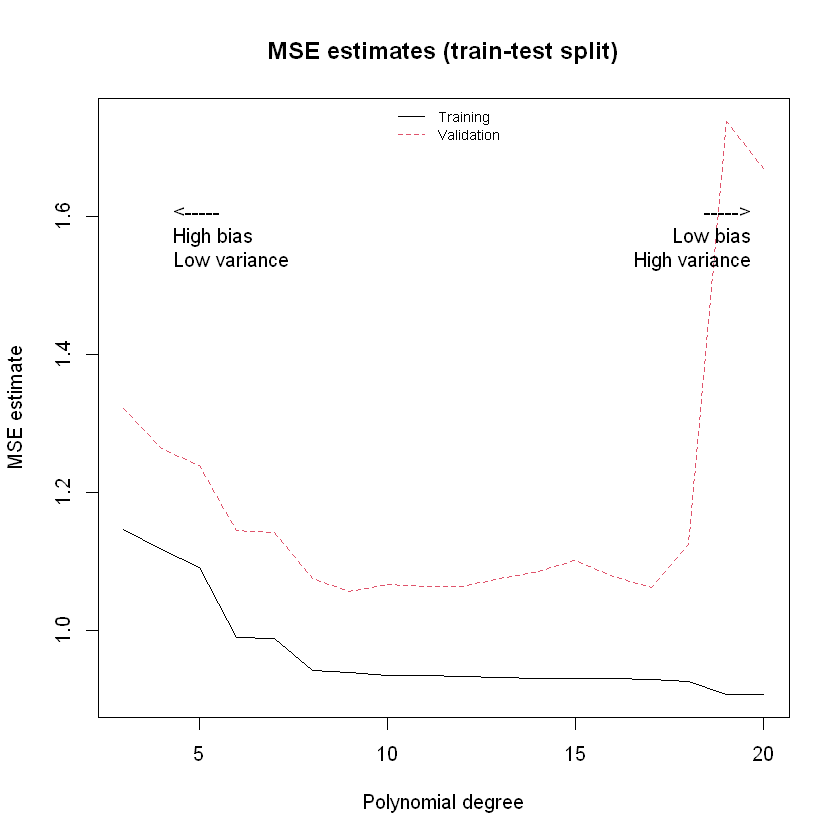

In [41]:
# polynomial degrees that we'll loop over
poly.degree <- seq(3, 20)

# training data observations: 1 to (n/2)
train <- 1:(n/2)

# looping over each polynomial degree
mse.estimates <- lapply(poly.degree, function(q) {

  # formula y ~ 1 + x1 + x1^2 + ... + x1^q
  fmla <- formula(paste0(outcome, "~ poly(", covariates[1], ",", q,")"))

  # linear regression using the formula above
  # note we're fitting only on the training data observations
  ols <- lm(fmla, data=data[train,])

  # predicting on the training subset
  # (no need to pass a dataframe)
  y.hat.train <- predict(ols)
  y.train <- data[train, outcome]
  
  # predicting on the validation subset
  # (the minus sign in "-train" excludes observations in the training data)
  y.hat.test <- predict(ols, newdata=data[-train,])
  y.test <- data[-train, outcome]
  
  # compute the mse estimate on the validation subset and output it
  data.frame(
    mse.train=mean((y.hat.train - y.train)^2),
    mse.test=mean((y.hat.test - y.test)^2))
  })
mse.estimates <- do.call(rbind, mse.estimates)

matplot(poly.degree, mse.estimates, type="l",  main="MSE estimates (train-test split)", ylab="MSE estimate", xlab="Polynomial degree")
text(poly.degree[2], .9*max(mse.estimates), pos=4, "<-----\nHigh bias\nLow variance") 
text(max(poly.degree), .9*max(mse.estimates), pos=2, "----->\nLow bias\nHigh variance") 
legend("top", legend=c("Training", "Validation"), bty="n", lty=1:2, col=1:2, cex=.7)


To make better use of the data we will often divide the data into $K$ subsets, or _folds_. Then one fits $K$ models, each using  $K-1$ folds and then evaluation the fitted model on the remaining fold. This is called **k-fold cross-validation**.

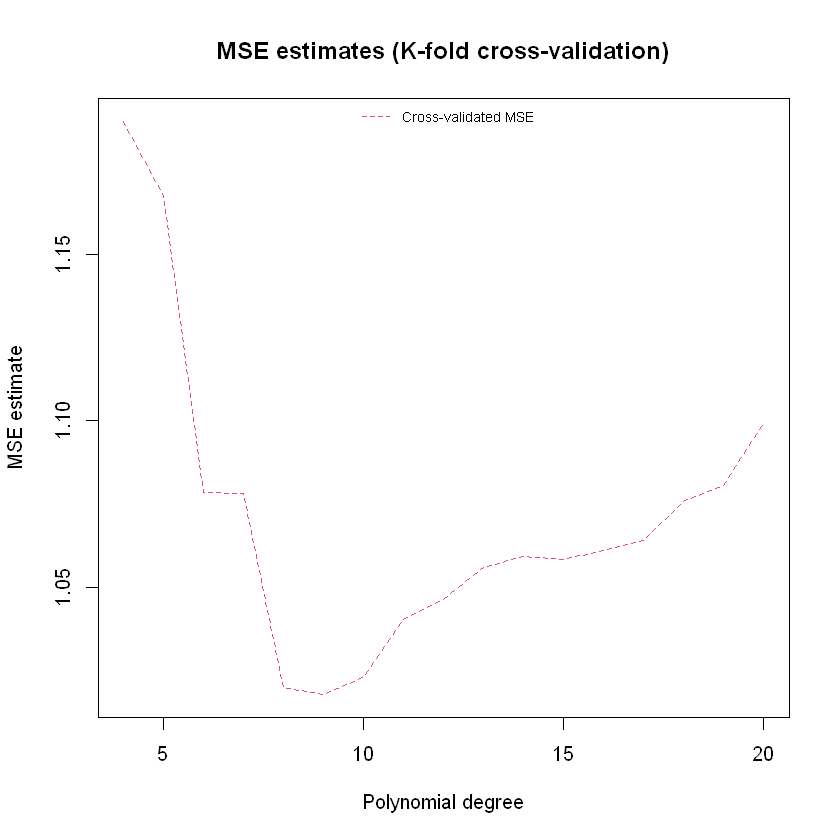

In [42]:
# number of folds (K)
n.folds <- 5

# polynomial degrees that we'll loop over to select
poly.degree <- seq(4, 20)

# list of indices that will be left out at each step
indices <- split(seq(n), sort(seq(n) %% n.folds))

# looping over polynomial degrees (q)
mse.estimates <- sapply(poly.degree, function(q) {

    # formula y ~ 1 + x1 + x1^2 + ... + x1^q
    fmla <- formula(paste0(outcome, "~ poly(", covariates[1], ",", q,")"))

    # loop over folds get cross-validated predictions
    y.hat <- lapply(indices, function(fold.idx) {

        # fit on K-1 folds, leaving out observations in fold.idx
        # (the minus sign in -fold.idx excludes those observations)
        ols <- lm(fmla, data=data[-fold.idx,])

        # predict on left-out kth fold
        predict(ols, newdata=data[fold.idx,])
    })
    # concatenate all the cross-validated predictions
    y.hat <- unname(unlist(y.hat))

    # cross-validated mse estimate
    mean((y.hat - data[, outcome])^2)
})

# plot
plot(poly.degree, mse.estimates, main="MSE estimates (K-fold cross-validation)", ylab="MSE estimate", xlab="Polynomial degree", type="l", lty=2, col=2)
legend("top", legend=c("Cross-validated MSE"), bty="n", lty=2, col=2, cex=.7)

A final remark is that, in machine learning applications, the complexity of the model often is allowed to increase with the available data. In the example above, even though we weren’t very successful when fitting a high-dimensional model on very little data, if we had much more data perhaps such a model would be appropriate. The next figure again fits a high order polynomial model, but this time on many data points. Note how, at least in data-rich regions, the model is much better behaved, and tracks the average outcome reasonably well without trying to interpolate wildly of the data points. 

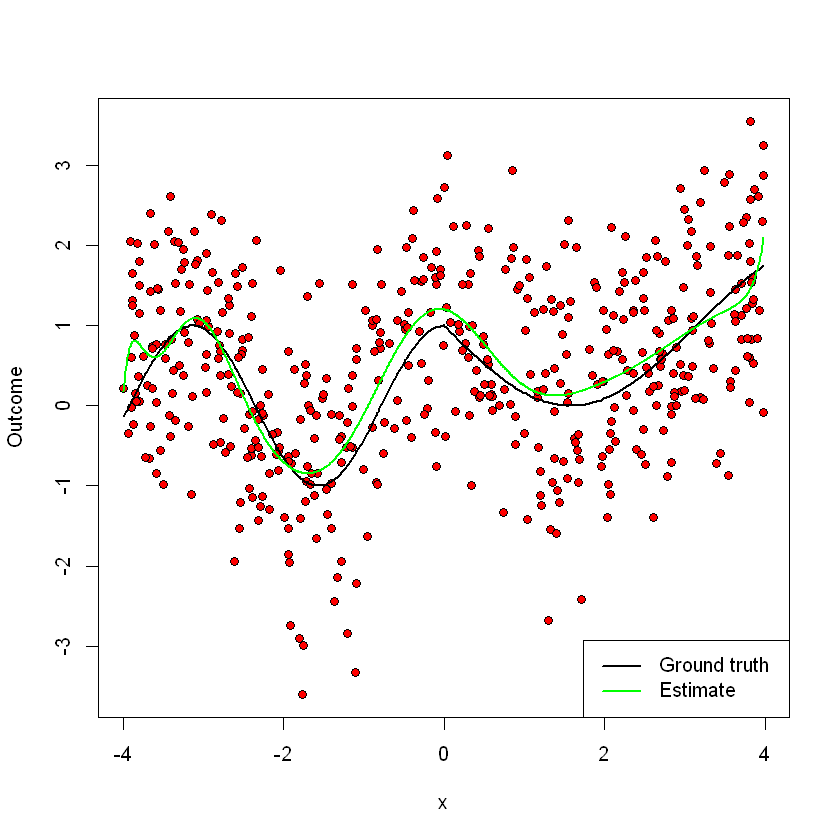

In [43]:
# Note this code assumes that the first covariate is continuous
# Fitting a flexible model on a lot of data

# now using much more data
subset <- 1:n

# formula for high order polynomial regression
# y ~ 1 + x1 + x1^2 + ... + x1^q
fmla <- formula(paste0(outcome, "~ poly(", covariates[1], ", 15)"))

# linear regression
ols <- lm(fmla, data, subset=subset)

# compute a grid of x1 values we'll use for prediction
x <- data[,covariates[1]]
x.grid <- seq(min(x), max(x), length.out=1000)
new.data <- data.frame(x.grid)
colnames(new.data) <- covariates[1]

# predict
y.hat <- predict(ols, newdata = new.data)

# plotting observations (in red) and model predictions (in green)
plot(data[subset, covariates[1]], data[subset, outcome], pch=21, bg="red", xlab=covariates[1], ylab="Outcome")
lines(x[order(x)], mu[order(x)], lwd=2, col="black")
lines(x.grid, y.hat, col="green", lwd=2)
legend("bottomright", lwd=2, lty=c(1, 1), col=c("black", "green"), legend=c("Ground truth", "Estimate"))

This is one of the benefits of using machine learning-based models: more data implies more flexible modeling, and therefore potentially better predictive power -- provided that we carefully avoid overfitting.

The example above based on polynomial regression was used mostly for illustration. In practice, there are often better-performing algorithms. We’ll see some of them next.



## 1.2 Common machine learning algorithms

Next, we’ll introduce three machine learning algorithms: (regularized) linear models, trees, and forests. Although this isn't an exhaustive list, these algorithms are common enough that every machine learning practitioner should know about them. They also have convenient `R` packages that allow for easy coding.

In this tutorial, we'll focus heavily on how to **interpret** the output of machine learning models -- or, at least, how not to _mis_-interpret it. However, in this chapter we won’t be making any causal claims about the relationships between variables yet. But please hang tight, as estimating causal effects will be one of the main topics presented in the next chapters.

For the remainder of the chapter we will use a real dataset. Each row in this data set represents the characteristics of a owner-occupied housing unit. Our goal is to predict the (log) price of the housing unit (`LOGVALUE`, our outcome variable) from features such as the size of the lot (`LOT`) and square feet area (`UNITSF`), number of bedrooms (`BEDRMS`) and bathrooms (`BATHS`), year in which it was built (`BUILT`) etc. This dataset comes from the American Housing Survey and was used in [Mullainathan and Spiess (2017, JEP)](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87). In addition, we will append to this data columns that are pure noise. Ideally, our fitted model should not take them into acccount.

In [44]:
# load dataset
data <- read.csv("https://docs.google.com/uc?id=1qHr-6nN7pCbU8JUtbRDtMzUKqS9ZlZcR&export=download")

# outcome variable name
outcome <- "LOGVALUE"

# covariates
true.covariates <- c('LOT','UNITSF','BUILT','BATHS','BEDRMS','DINING','METRO','CRACKS','REGION','METRO3','PHONE','KITCHEN','MOBILTYP','WINTEROVEN','WINTERKESP','WINTERELSP','WINTERWOOD','WINTERNONE','NEWC','DISH','WASH','DRY','NUNIT2','BURNER','COOK','OVEN','REFR','DENS','FAMRM','HALFB','KITCH','LIVING','OTHFN','RECRM','CLIMB','ELEV','DIRAC','PORCH','AIRSYS','WELL','WELDUS','STEAM','OARSYS')
p.true <- length(true.covariates)

# noise covariates added for didactic reasons
p.noise <- 20
noise.covariates <- paste0('noise', seq(p.noise))
covariates <- c(true.covariates, noise.covariates)
X.noise <- matrix(rnorm(n=nrow(data)*p.noise), nrow(data), p.noise)
colnames(X.noise) <- noise.covariates
data <- cbind(data, X.noise)

# sample size
n <- nrow(data)

# total number of covariates
p <- length(covariates)


Here's the correlation between the first few covariates. Note how, most variables are positively correlated, which is expected since houses with more bedrooms will usually also have more bathrooms, larger area, etc.

In [45]:
round(cor(data[,covariates[1:8]]), 3)

,LOT,UNITSF,BUILT,BATHS,BEDRMS,DINING,METRO,CRACKS
LOT,1.000,0.065,0.045,0.057,0.010,-0.015,0.136,0.017
UNITSF,0.065,1.000,0.143,0.429,0.361,0.214,0.057,0.034
BUILT,0.045,0.143,1.000,0.435,0.215,0.037,0.324,0.092
BATHS,0.057,0.429,0.435,1.000,0.540,0.259,0.190,0.063
BEDRMS,0.010,0.361,0.215,0.540,1.000,0.282,0.121,0.027
DINING,-0.015,0.214,0.037,0.259,0.282,1.000,0.022,0.021
METRO,0.136,0.057,0.324,0.190,0.121,0.022,1.000,0.058
CRACKS,0.017,0.034,0.092,0.063,0.027,0.021,0.058,1.000


### 1.2.1 Generalized linear models

This class of models extends common methods such as linear and logistic regression by adding a penalty to the magnitude of the coefficients. **Lasso** penalizes the absolute value of slope coefficients. For regression problems, it becomes
$$
  (\#eq:lasso)
  \hat{b}_{Lasso} = \arg\min_b \sum_{i=1}^m
    \left( Y_i - b_0 - X_{i1}b_1 - \cdots - X_{ip}b_p \right)^2
    - \lambda \sum_{j=1}^p |b_j|
$$ (eq:lasso)


Similarly, in a regression problem **Ridge** penalizes the sum of squares of the slope coefficients,

$$
  (\#eq:ridge)
  \hat{b}_{Ridge} = \arg\min_b \sum_{i=1}^m
    \left( Y_i - b_0 - X_{i1}b_1 - \cdots - X_{ip}b_p \right)^2
    - \lambda \sum_{j=1}^p b_j^2
$$ (eq:ridge)

Also, there exists the **Elastic Net** penalization which consists of a convex combination between the other two. In all cases, the scalar parameter
$\lambda$ controls the complexity of the model. For $\lambda=0$, the problem reduces to the “usual” linear regression. As $\lambda$ increases, we favor simpler models. As we’ll see below, the optimal parameter $\lambda$ is selected via cross-validation.

An important feature of Lasso-type penalization is that it promotes **sparsity** – that is, it forces many coefficients to be exactly zero. This is different from Ridge-type penalization, which forces coefficients to be small.

Another interesting property of these models is that, even though they are called “linear” models, this should actually be understood as **linear in transformations** of the covariates. For example, we could use polynomials or splines (continuous piecewise polynomials) of the covariates and allow for much more flexible models.

In fact, because of the penalization term, problems {q}`lasso` and {q}`ridge` remain well-defined and have a unique solution even in **high-dimensional** problems in which the number of coefficients $p$ is larger than the sample size $n$ – that is, our data is “fat” with more columns than rows. These situations can arise either naturally (e.g. genomics problems in which we have hundreds of thousands of gene expression information for a few individuals) or because we are including many transformations of a smaller set of covariates.

Finally, although here we are focusing on regression problems, other generalized linear models such as logistic regression can also be similarly modified by adding a Lasso, Ridge, or Elastic Net-type penalty to similar consequences.

In our example we will use the `glmnet` package; see this [vignette](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) for more information about the package, including how to use glmnet for other types of outcomes (binomial, categorical, multi-valued). The function `cv.glmnet` automatically performs k-fold cross-validation.

Also, to emphasize the point about linearity in transformations of the covariates, we will use splines of our independent variables (i.e., we will use piecewise continuous polynomials of the original covariates). This is done using the function `bs`; see this [primer](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf) for more information.

In [46]:
# A formula of type "~ x1 + x2 + ..." (right-hand side only) to
# indicate how covariates should enter the model. If you'd like to add, e.g.,
# third-order polynomials in x1, you could do so here by modifying the formula
# to be something like  "~ poly(x1, 3) + x2 + ..."
fmla <- formula(paste(" ~ 0 + ", paste0(covariates, collapse=" + ")))

# Use this formula instead if you'd like to fit on piecewise polynomials
# fmla <- formula(paste(" ~ 0 + ", paste0("bs(", covariates, ", df=5)", collapse=" + ")))

# Function model.matrix selects the covariates according to the formula
# above and expands the covariates accordingly. In addition, if any column
# is a factor, then this creates dummies (one-hot encoding) as well.
XX <- model.matrix(fmla, data)
Y <- data[, outcome]

# Fit a lasso model.
# Note this automatically performs cross-validation.
lasso <- cv.glmnet(
  x=XX, y=Y,
  family="gaussian", # use 'binomial' for logistic regression
  alpha=1. # use alpha=0 for ridge, or alpha in (0, 1) for elastic net
)

The next figure plots the average estimated MSE for each lambda. The red dots are the averages across all folds, and the error bars are based on the variability of mse estimates across folds. The vertical dashed lines show the (log) lambda with smallest estimated MSE (left) and the one whose mse is at most one standard error from the first (right).

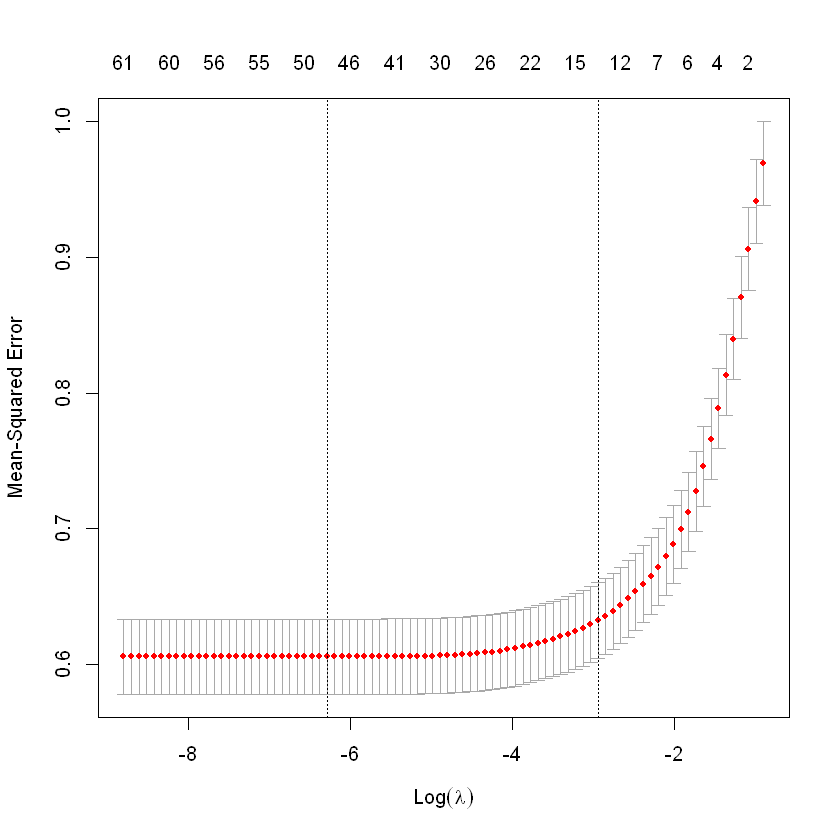

In [47]:
plot(lasso)

Here are the first few estimated coefficients at the $\lambda$ value that minimizes cross-validated MSE. Note that many estimated coefficients them are exactly zero

In [48]:
# Estimated coefficients at the lambda value that minimized cross-validated MSE
coef(lasso, s = "lambda.min")[1:5,]  # showing only first coefficients
print(paste("Number of nonzero coefficients at optimal lambda:", lasso$nzero[which.min(lasso$cvm)], "out of", length(coef(lasso))))

(Intercept)          LOT       UNITSF        BUILT        BATHS 
1.183627e+01 3.394000e-07 2.230400e-05 1.417298e-04 2.477548e-01

[1] "Number of nonzero coefficients at optimal lambda: 49 out of 64"


Predictions and estimated MSE for the selected model are retrieved as follows.

In [49]:
# Retrieve predictions at best lambda regularization parameter
y.hat <- predict(lasso, newx=XX, s="lambda.min", type="response")

# Get k-fold cross validation
mse.glmnet <- lasso$cvm[lasso$lambda == lasso$lambda.min]
print(paste("glmnet MSE estimate (k-fold cross-validation):", mse.glmnet))

[1] "glmnet MSE estimate (k-fold cross-validation): 0.605862665474721"


The next command plots estimated coefficients as a function of the regularization parameter $\lambda$.

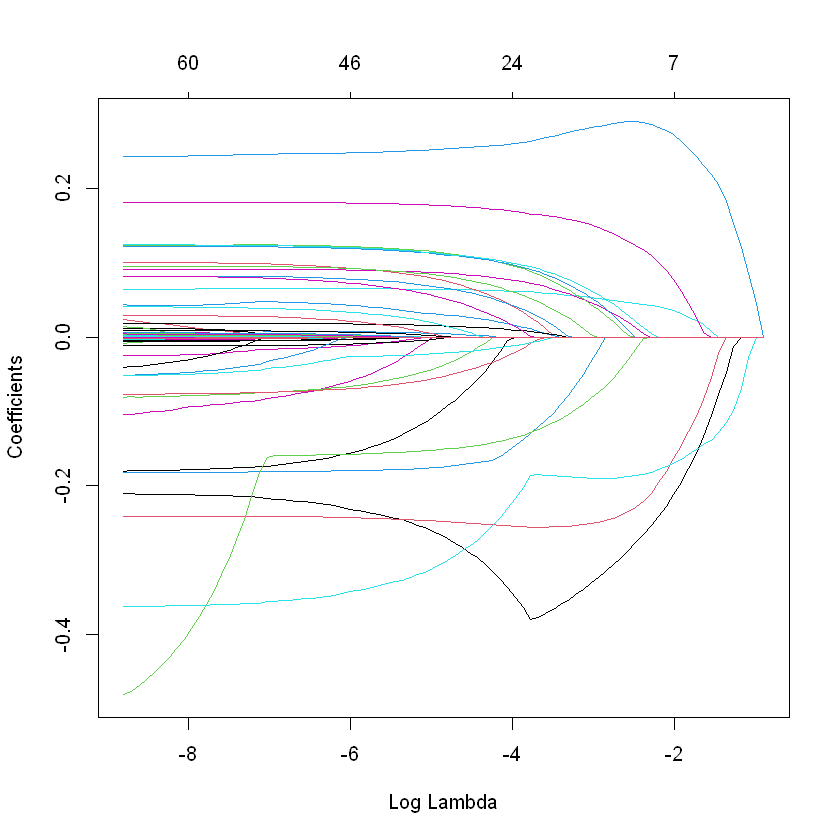

In [50]:
plot(lasso$glmnet.fit, xvar="lambda")

It's tempting to try to interpret the coefficients obtained via Lasso. Unfortunately, that can be very difficult, because by dropping covariates Lasso introduces a form of **omitted variable bias** ([wikipedia](https://en.wikipedia.org/wiki/Omitted-variable_bias)). To understand this form of bias, consider the following toy example. We have two positively correlated independent variables, `x.1` and `x.2`, that are linearly related to the outcome `y`. Linear regression of `y` on `x1` and `x2` gives us the correct coefficients. However, if we _omit_ `x2` from the estimation model, the coefficient on `x1` increases. This is because `x1` is now "picking up" the effect of the variable that was left out. In other words, the effect of `x1` seems stronger because we aren't controlling for some other confounding variable. Note that the second model this still works for prediction, but we cannot interpret the coefficient as a measure of strength of the causal relationship between `x1` and `y`.

In [51]:
# Generating some data 
# y = 1 + 2*x1 + 3*x2 + noise, where corr(x1, x2) = .5
# note the sample size is very large -- this isn't solved by big data!
x <- mvrnorm(100000, mu=c(0,0), Sigma=diag(c(.5,.5)) + 1)
y <- 1 + 2*x[,1] + 3*x[,2] + rnorm(100000)
data.sim <- data.frame(x=x, y=y)

print("Correct model")
lm(y ~ x.1 + x.2, data.sim)

print("Model with omitted variable bias")
lm(y ~ x.1, data.sim)

[1] "Correct model"



Call:
lm(formula = y ~ x.1 + x.2, data = data.sim)

Coefficients:
(Intercept)          x.1          x.2  
      1.004        2.002        2.995  


[1] "Model with omitted variable bias"



Call:
lm(formula = y ~ x.1, data = data.sim)

Coefficients:
(Intercept)          x.1  
      1.004        4.002  


The phenomenon above occurs in Lasso and in any other sparsity-promoting method when correlated covariates are present since, by forcing coefficients to be zero, Lasso is effectively dropping them from the model. And as we have seen, as a variable gets dropped, a different variable that is correlated with it can "pick up" its effect, which in turn can cause bias. Once $\lambda$ grows sufficiently large, the penalization term overwhelms any benefit of having that variable in the model, so that variable finally decreases to zero too.

One may instead consider using Lasso to select a subset of variables, and then regressing the outcome on the subset of selected variables via OLS (without any penalization). This method is often called **post-lasso**. Although it has desirable properties in terms of model fit (see e.g., [Belloni and Chernozhukov, 2013](https://arxiv.org/pdf/1001.0188.pdf)), this procedure does not solve the omitted variable issue we mentioned above.

We illustrate this next. We observe the path of the estimated coefficient on the number of bathroooms (`BATHS`) as we increase $\lambda$.

In [52]:
# prepare data
fmla <- formula(paste0(outcome, "~", paste0(covariates, collapse="+")))
XX <- model.matrix(fmla, data)[,-1]  # [,-1] drops the intercept
Y <- data[,outcome]

# fit ols, lasso and ridge models
ols <- lm(fmla, data)
lasso <- cv.glmnet(x=XX, y=Y, alpha=1.)  # alpha = 1 for lasso
ridge <- cv.glmnet(x=XX, y=Y, alpha=0.)  # alpha = 0 for ridge

# retrieve ols, lasso and ridge coefficients
lambda.grid <- c(0, sort(lasso$lambda))
ols.coefs <- coef(ols)
lasso.coefs <- as.matrix(coef(lasso, s=lambda.grid))
ridge.coefs <- as.matrix(coef(ridge, s=lambda.grid))

# loop over lasso coefficients and re-fit OLS to get post-lasso coefficients
plasso.coefs <- apply(lasso.coefs, 2, function(beta) {

    # which slopes are non-zero
    non.zero <- which(beta[-1] != 0)  # [-1] excludes intercept

    # if there are any non zero coefficients, estimate OLS
    fmla <- formula(paste0(outcome, "~", paste0(c("1", covariates[non.zero]), collapse="+")))
    beta <- rep(0, ncol(XX) + 1)

    # populate post-lasso coefficients
    beta[c(1, non.zero + 1)] <- coef(lm(fmla, data))

    beta
  })

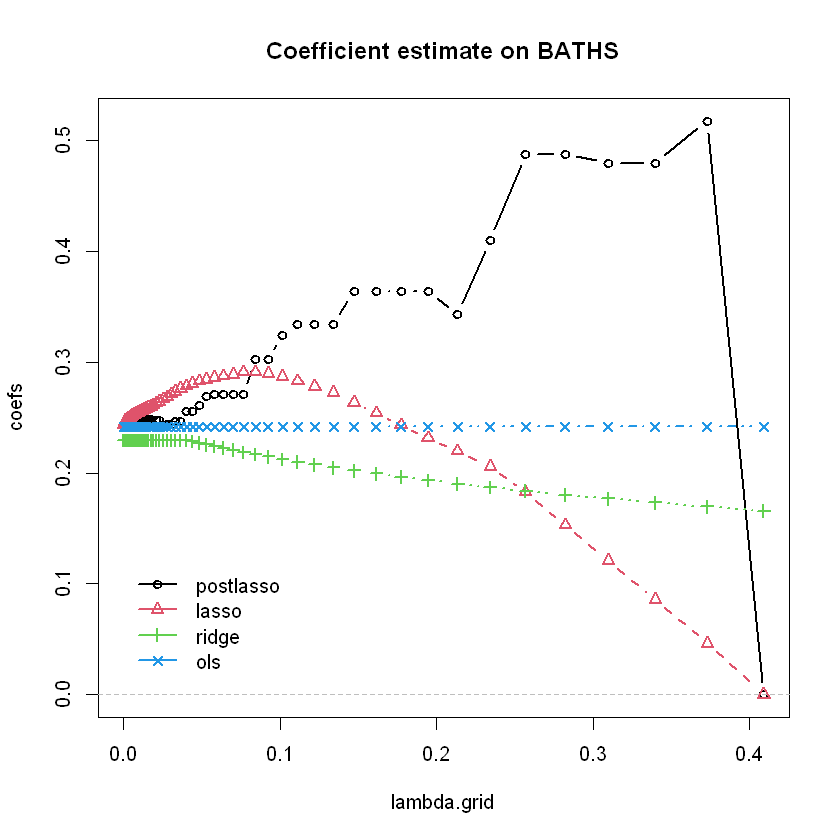

In [53]:
selected <- 'BATHS'
k <- which(rownames(lasso.coefs) == selected) # index of coefficient to plot
coefs <- cbind(postlasso=plasso.coefs[k,],  lasso=lasso.coefs[k,], ridge=ridge.coefs[k,], ols=ols.coefs[k])
matplot(lambda.grid, coefs, col=1:4, type="b", pch=1:4, lwd=2, main=paste("Coefficient estimate on", selected))
abline(h = 0, lty="dashed", col="gray")

legend("bottomleft",
  legend = colnames(coefs),
  bty="n", col=1:4,  pch=1:4, inset=c(.05, .05), lwd=2)

The OLS coefficients are not penalized, so they remain constant. Ridge estimates decrease monotonically as $\lambda$ grows. Also, for this dataset, Lasso estimates first increase and then decrease. Meanwhile, the post-lasso coefficient estimates seem to behave somewhat erratically with $lambda$. To understand this behavior, let's see what happens to the magnitude of other selected variables that are correlated with `BATHS`. 

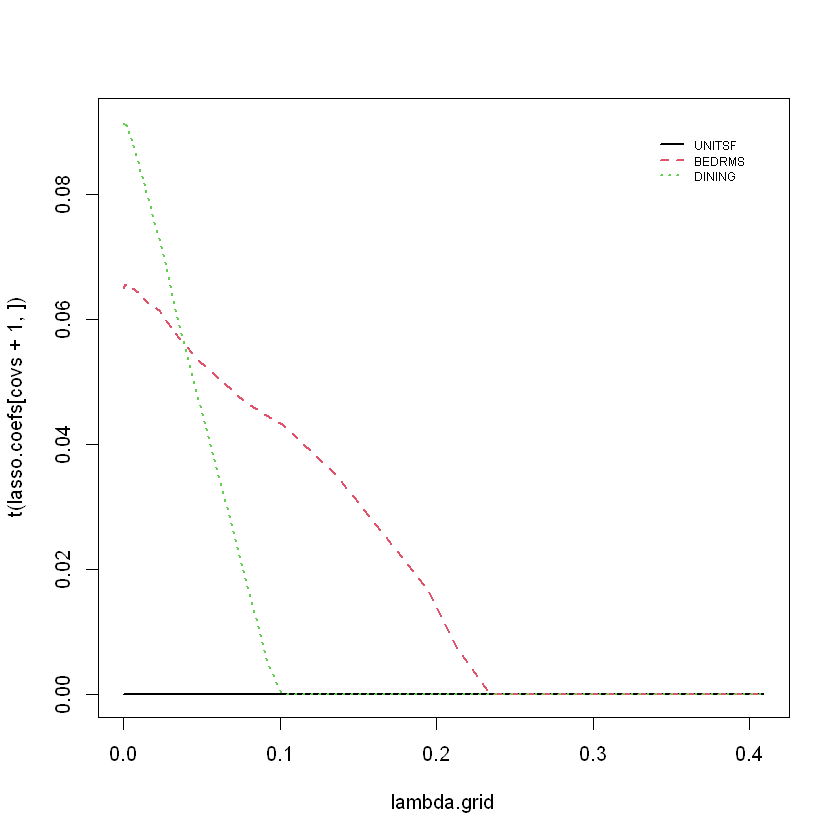

In [54]:
covs <- which(covariates %in% c('UNITSF', 'BEDRMS',  'DINING'))
matplot(lambda.grid, t(lasso.coefs[covs+1,]), type="l", lwd=2)
legend("topright", legend = covariates[covs], bty="n", col=1:p,  lty=1:p, inset=c(.05, .05), lwd=2, cex=.6)

Note how the discrete jumps in magnitude for the `BATHS` coefficient in the first coincide with, for example, variables `DINING` and `BEDRMS` being exactly zero. As these variables got dropped from the model, the coefficient on `BATHS` increased to pick up their effect. 

Another problem with Lasso coefficients is their instability. When multiple variables are highly correlated we may spuriously drop several of them. To get a sense of the amount of variability, in the next snippet we fix $\lambda$ and then look at the lasso coefficients estimated during cross-validation. We see that by simply removing one fold we can get a very different set of coefficients (nonzero coefficients are in black in the heatmap below). This is because there may be many choices of coefficients with similar predictive power, so the set of nonzero coefficients we end up with can be quite unstable.

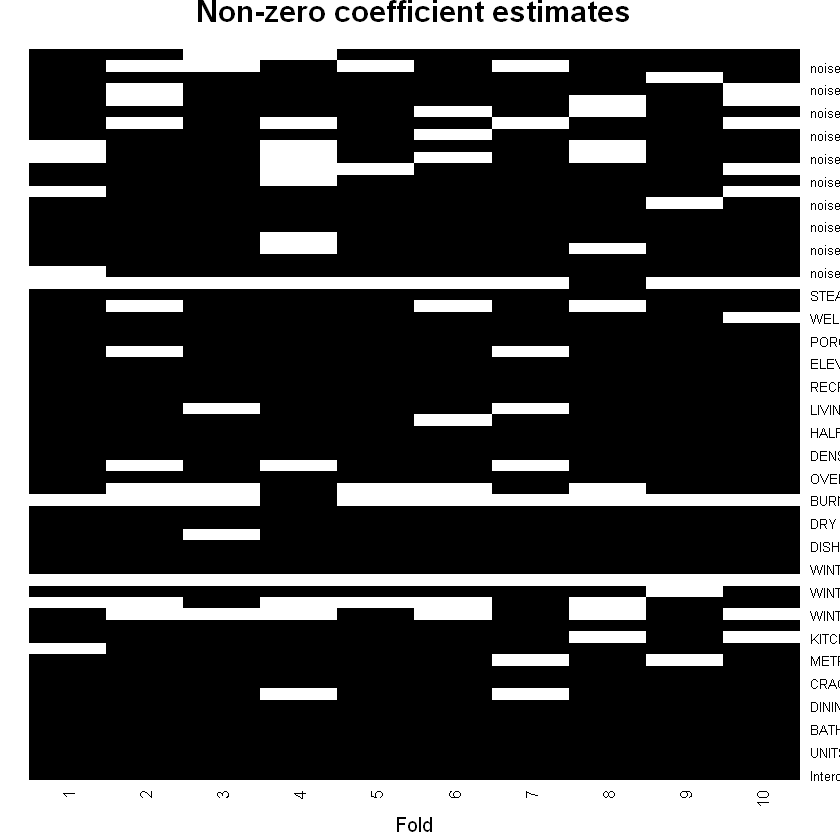

In [55]:
# Fixing lambda. This choice is not very important; the same occurs any intermediate lambda value.
selected.lambda <- lasso$lambda.min
n.folds <- 10
foldid <- (seq(n) %% n.folds) + 1
coefs <- sapply(seq(n.folds), function(k) {
  lasso.fold <- glmnet(XX[foldid == k,], Y[foldid == k])
  as.matrix(coef(lasso.fold, s=selected.lambda))
})
heatmap(1*(coefs != 0), Rowv = NA, Colv = NA, cexCol = 1, scale="none", col=gray(c(1,0)), margins = c(3, 1), xlab="Fold", labRow=c("Intercept", covariates), main="Non-zero coefficient estimates")

As we have seen above, any interpretation needs to take into account the joint distribution of covariates. One possible heuristic is to consider **data-driven subgroups**. For example, we can analyze what differentiates observations whose predictions are high from those whose predictions are low. The following code estimates a flexible Lasso model with splines, ranks the observations into a few subgroups according to their predicted outcomes, and then estimates the average covariate value for each subgroup.  

In [56]:
# Number of data-driven subgroups.
num.groups <- 4

# Fold indices
n.folds <- 5
foldid <- (seq(n) %% n.folds) + 1

fmla <- formula(paste(" ~ 0 + ", paste0("bs(", covariates, ", df=3)", collapse=" + ")))

# Function model.matrix selects the covariates according to the formula
# above and expands the covariates accordingly. In addition, if any column
# is a factor, then this creates dummies (one-hot encoding) as well.
XX <- model.matrix(fmla, data)
Y <- data[, outcome]

# Fit a lasso model.
# Passing foldid argument so we know which observations are in each fold.
lasso <- cv.glmnet(x=XX, y=Y, foldid = foldid, keep=TRUE)

y.hat <- predict(lasso, newx = XX, s = "lambda.min")

# Ranking observations.
ranking <- lapply(seq(n.folds), function(i) {

    # Extract cross-validated predictions for remaining fold.
    y.hat.cross.val <- y.hat[foldid == i]

    # Find the relevant subgroup break points
    qs <- quantile(y.hat.cross.val, probs = seq(0, 1, length.out=num.groups + 1))

    # Rank observations into subgroups depending on their predictions
    cut(y.hat.cross.val, breaks = qs, labels = seq(num.groups))
  })
ranking <- factor(do.call(c, ranking))

# Estimate expected covariate per subgroup
avg.covariate.per.ranking <- mapply(function(x.col) {
  fmla <- formula(paste0(x.col, "~ 0 + ranking"))
  ols <- lm(fmla, data=transform(data, ranking=ranking))
  t(lmtest::coeftest(ols, vcov=vcovHC(ols, "HC2"))[, 1:2])
}, covariates, SIMPLIFY = FALSE)

avg.covariate.per.ranking[1:2]

,ranking1,ranking2,ranking3,ranking4
Estimate,48263.573,44814.350,49271.020,49267.689
Std. Error,1432.223,1298.571,1486.012,1461.595
,ranking1,ranking2,ranking3,ranking4
Estimate,2423.62996,2433.1772,2428.63689,2434.72284
Std. Error,25.19218,24.9452,24.55653,24.25453


The next heatmap visualizes the results. Note how observations ranked higher (i.e., were predicted to have higher prices) have more bedrooms and baths, were built more recently, have fewer cracks, and so on. The next snippet of code displays the average covariate per group along with each standard errors. The rows are ordered according to $Var(E[X_{ij} | G_i) / Var(X_i)$, where $G_i$ denotes the ranking. This is a rough normalized measure of how much variation is "explained" by group membership $G_i$. Brighter colors indicate larger values.

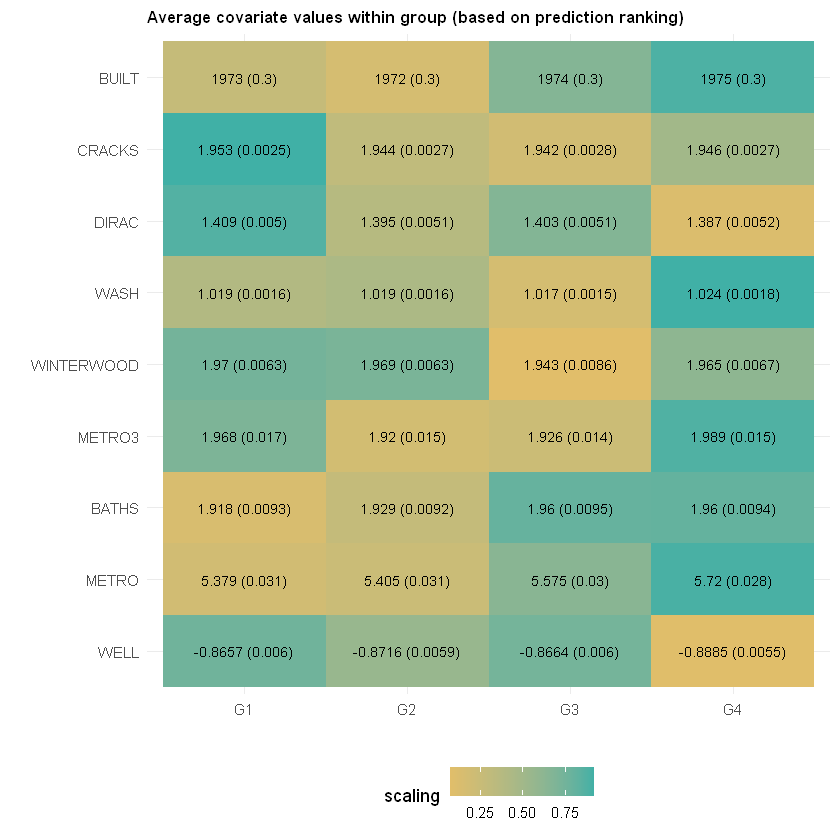

In [57]:
df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per ranking (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + ranking"))
      ols <- lm(fmla, data=transform(data, ranking=ranking))
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, ranking=paste0("G", seq(num.groups)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(data[,covariate]),
                 # String to print in each cell in heatmap below
                 # Note: depending on the scaling of your covariates, 
                 # you may have to tweak these formatting parameters a little.
                 labels=paste0(formatC(avg),  " (", formatC(stderr, digits = 2, width = 2), ")"))
}, covariates, SIMPLIFY = FALSE)
df <- do.call(rbind, df)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))
df <- df[order(df$variation, decreasing=TRUE),]

# plot heatmap
ggplot(df[1:(9*num.groups),]) +  # showing on the first few results (ordered by 'variation')
    aes(ranking, covariate) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels), size=3) +  # 'size' controls the fontsize inside cell
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within group (based on prediction ranking)")) +
    theme_minimal() + 
    ylab("") + xlab("") +
    theme(plot.title = element_text(size = 10, face = "bold"),
          legend.position="bottom")

As we just saw above, houses that have, e.g., been built more recently (`BUILT`), have more baths (`BATHS`) are associated with larger price predictions.

This sort of interpretation exercise did not rely on reading any coefficients, and in fact it could also be done using any other flexible method, including decisions trees and forests.


### 1.2.2 Decision trees

This next class of algorithms divides the covariate space into "regions" and estimates a constant prediction within each region.

To estimate a decision tree, we following a recursive partition algorithm. At each stage, we select one variable $j$ and one split point
$s$, and divide the observations into “left” and “right” subsets, depending on whether $X_{ij} \leq s$ or $X_{ij} > s$. For regression problems, the variable and split points are often selected so that the sum of the variances of the outcome variable in each “child” subset is smallest. For classification problems, we split to separate the classes. Then, for each child, we separately repeat the process of finding variables and split points. This continues until a minimum subset size is reached, or improvement falls below some threshold.

At prediction time, to find the predictions for some point $x$, we just follow the tree we just built, going left or right according to the selected variables and split points, until we reach a terminal node. Then, for regression problems, the predicted value at some point $x$ is the average outcome of the observations in the same partition as the point $x$. For classification problems, we output the majority class in the node.

Let’s estimate a decision tree using the `R` package rpart; see [this tutorial](https://cran.r-project.org/web/packages/rpart/vignettes/longintro.pdf) for more information about it.

In [58]:
# Fit tree without pruning first
fmla <- formula(paste(outcome, "~", paste(covariates, collapse=" + ")))
tree <- rpart(fmla, data=data, cp=0, method="anova")  # use method="class" for classification

At this point, we have not constrained the complexity of the tree in any way, so it's likely too deep and probably overfits. Here’s a plot of what we have so far (without bothering to label the splits to avoid clutter).

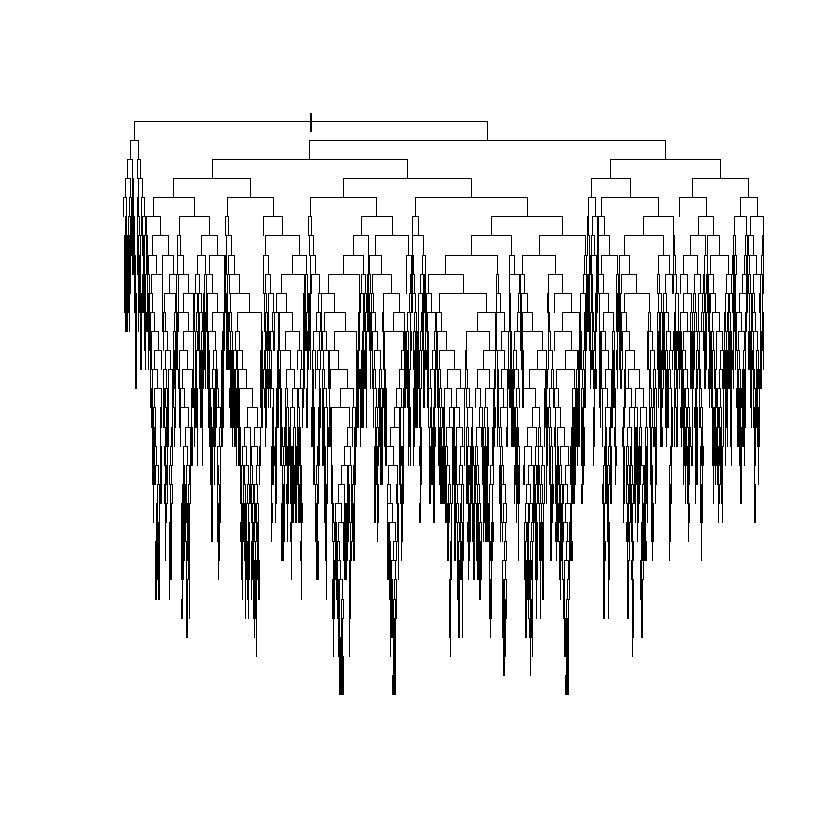

In [59]:
plot(tree, uniform=TRUE)

To reduce the complexity of the tree, we **prune** the tree: we collapse its leaves, permitting bias to increase but forcing variance to decrease until the desired trade-off is achieved. In `rpart`, this is done by considering a modified loss function that takes into account the number of terminal nodes (i.e., the number of regions in which the original data was partitioned). Somewhat heuristically, if we denote tree predictions by $T(x)$ and its number of terminal nodes by  $|T|$, the modified regression problem can be written as:

$$
  (#eq:tree-cp)
  \widehat{T} = \arg\min_{T} \sum_{i=1}^m \left( T(X_i) - Y_i \right)^2 + c_p |T|
$$ (tree-cp)


The complexity of the tree is controlled by the scalar parameter $c_p$, denoted as `cp` in `rpart`. For each value of $c_p$, we find the subtree that solves {eq}`tree-cp`. Large values of $c_p$ lead to aggressively pruned trees, which have more bias and less variance. Small values of $c_p$ allow for deeper trees whose predictions can vary more wildly. The plot below shows the cross-validated error (relative to a tree with only one node, which corresponds to predicting the sample mean everywhere) for trees obtained at different levels of  $c_p$. The bias-variance trade-off is optimized at the point at which the cross-validated error is minimized.

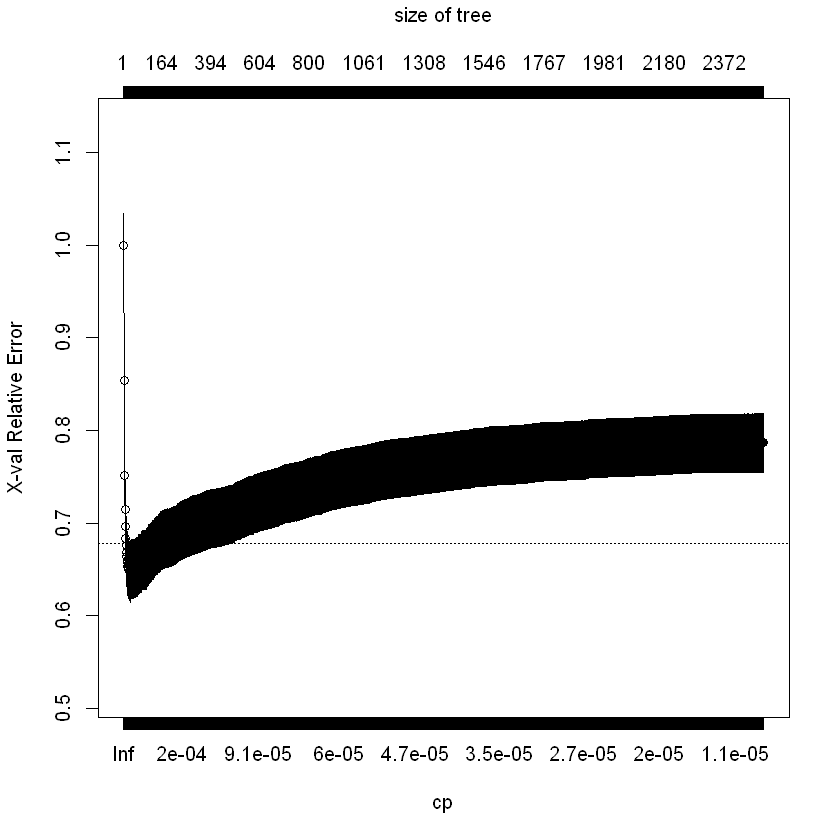

In [60]:
plotcp(tree)

The following code retrieves the optimal parameter and prunes the tree. Here, instead of choosing the parameter that minimizes the mean-squared-error, we're following another common heuristic: we will choose the most regularized model whose error is within one standard error of the minimum error.

In [61]:
# Retrieves the optimal parameter
cp.min <- which.min(tree$cptable[,"xerror"]) # minimum error
cp.idx <- which(tree$cptable[,"xerror"] - tree$cptable[cp.min,"xerror"] < tree$cptable[,"xstd"])[1]  # at most one std. error from minimum error
cp.best <- tree$cptable[cp.idx,"CP"]

# Prune the tree
pruned.tree <- prune(tree, cp=cp.best)

Plotting the pruned tree. See also the package [rpart.plot](http://www.milbo.org/rpart-plot/prp.pdf) for more advanced plotting capabilities.

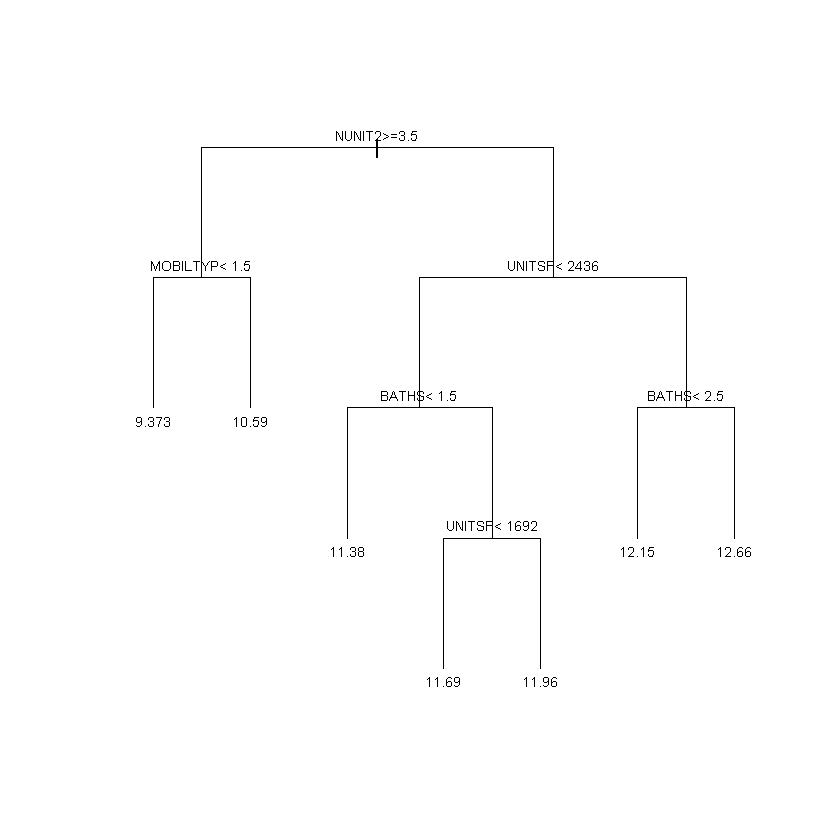

In [62]:
plot(pruned.tree, uniform=TRUE, margin = .05)
text(pruned.tree, cex=.7)

Finally, here’s how to extract predictions and mse estimates from the pruned tree.

In [63]:
# Retrieve predictions from pruned tree
y.hat <- predict(pruned.tree)

# Compute mse for pruned tree (using cross-validated predictions)
mse.tree <- mean((xpred.rpart(tree)[,cp.idx] - data[,outcome])^2, na.rm=TRUE)
print(paste("Tree MSE estimate (cross-validated):", mse.tree))

[1] "Tree MSE estimate (cross-validated): 0.655394075884523"


It’s often said that trees are "interpretable." To some extent, that’s true – we can look at the tree and clearly visualize the mapping from inputs to prediction. This can be important in settings in which conveying how one got to a prediction is important. For example, if a decision tree were to be used for credit scoring, it would be easy to explain to a client how their credit was scored.

Beyond that, however, there are several reasons for not interpreting the obtained decision tree further. First, even though a tree may have used a particular variable for a split, that does not mean that it’s indeed an important variable: if two covariates are highly correlated, the tree may split on one variable but not the other, and there’s no guarantee which variables are relevant in the underlying data-generating process.

Similar to what we did for Lasso above, we can estimate the average value of each covariate per leaf. Although results are noisier here because there are many leaves, we see somewhat similar trends in that houses with higher predictions are also correlated with more bedrooms, bathrooms and room sizes.

In [64]:
y.hat <- predict(pruned.tree)

# Number of leaves should equal the number of distinct prediction values.
# This should be okay for most applications, but if an exact answer is needed use
# predict.rpart.leaves from package treeCluster
num.leaves <- length(unique(y.hat))

# Leaf membership, ordered by increasing prediction value
leaf <- factor(y.hat, ordered = TRUE, labels = seq(num.leaves))

# Looping over covariates
avg.covariate.per.leaf <- mapply(function(covariate) {
  
  # Coefficients on linear regression of covariate on leaf 
  #  are the average covariate value in each leaf.
  # covariate ~ leaf.1 + ... + leaf.L 
  fmla <- formula(paste0(covariate, "~ 0 + leaf"))
  ols <- lm(fmla, data=transform(data, leaf=leaf))
  
  # Heteroskedasticity-robust standard errors
  t(coeftest(ols, vcov=vcovHC(ols, "HC2"))[,1:2])
}, covariates, SIMPLIFY = FALSE)

print(avg.covariate.per.leaf[1:2])  # Showing only first few

$LOT
               leaf1      leaf2    leaf3     leaf4     leaf5     leaf6
Estimate   69442.743 134663.235 37833.61 36568.902 46578.990 55894.077
Std. Error  6146.155   9742.853  1265.77  1376.299  1335.717  2043.282
               leaf7
Estimate   61681.880
Std. Error  2243.882

$UNITSF
                leaf1      leaf2       leaf3      leaf4      leaf5      leaf6
Estimate   1360.79394 1850.45404 1557.508744 1370.26146 2085.77359 3781.07702
Std. Error   46.56963   66.18601    6.655404    3.21795    2.78384   43.78579
                leaf7
Estimate   4912.32614
Std. Error   57.25873



Finally, as we did in the linear model case, we can use the same code for an annotated version of the same information. Again, we ordered the rows in decreasing order based on an estimate of the relative variance "explained" by leaf membership: $Var(E[X_i|L_i]) / Var(X_i)$, where $L_i$ represents the leaf.

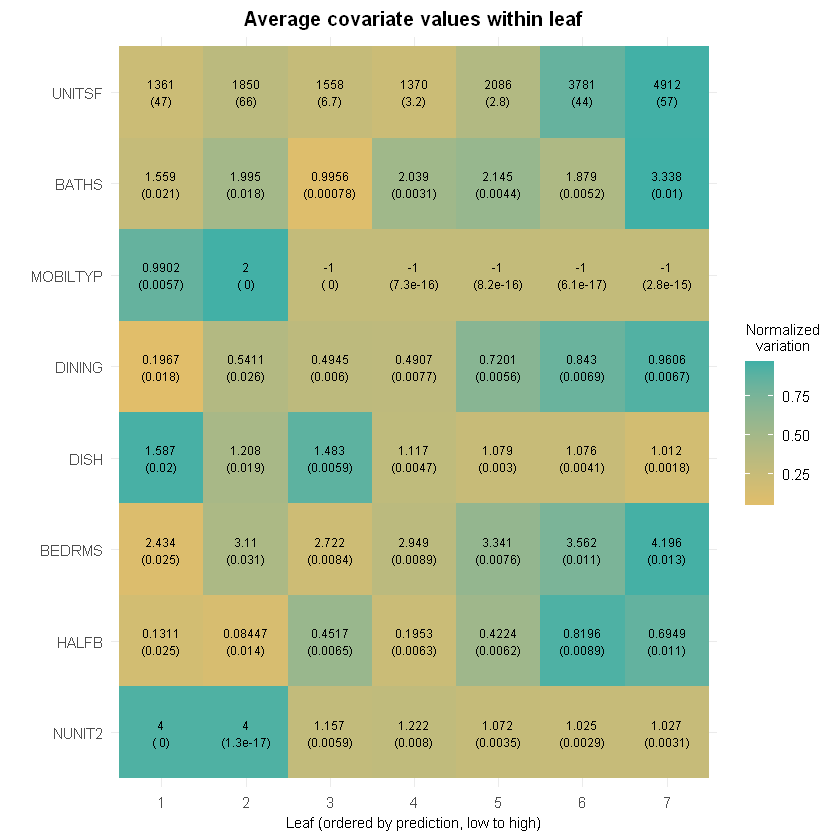

In [65]:
df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per ranking (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + leaf"))
      ols <- lm(fmla, data=transform(data, leaf=leaf))
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, 
                 ranking=factor(seq(num.leaves)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(data[,covariate]),
                 # String to print in each cell in heatmap below
                 # Note: depending on the scaling of your covariates, 
                 # you may have to tweak these  formatting parameters a little.
                 labels=paste0(formatC(avg),"\n(", formatC(stderr, digits = 2, width = 2), ")"))
}, covariates, SIMPLIFY = FALSE)
df <- do.call(rbind, df)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))
df <- df[order(df$variation, decreasing=TRUE),]

# plot heatmap
ggplot(df[1:(8*num.leaves),]) +  # showing on the first few results (ordered by 'variation')
    aes(ranking, covariate) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels), size=2.5) +  # 'size' controls the fontsize inside cell
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within leaf")) +
    theme_minimal() + 
    ylab("") + xlab("Leaf (ordered by prediction, low to high)") +
    labs(fill="Normalized\nvariation") +
    theme(plot.title = element_text(size = 12, face = "bold", hjust = .5),
          axis.title.x = element_text(size=9),
          legend.title = element_text(hjust = .5, size=9))


### 1.2.3 Forests

Forests are a type of **ensemble** estimators: they aggregate information about many decision trees to compute a new estimate that typically has much smaller variance.

At a high level, the process of fitting a (regression) forest consists of fitting many decision trees, each on a different subsample of the data. The forest prediction for a particular point $x$ is the average of all tree predictions for that point.

One interesting aspect of forests and many other ensemble methods is that cross-validation can be built into the algorithm itself. Since each tree only uses a subset of the data, the remaining subset is effectively a test set for that tree. We call these observations **out-of-bag** (there were not in the “bag” of training observations). They can be used to evaluate the performance of that tree, and the average of out-of-bag evaluations is evidence of the performance of the forest itself.

For the example below, we’ll use the regression_forest function of the `R` package `grf`. The particular forest implementation in `grf` has interesting properties that are absent from most other packages. For example, trees are build using a certain sample-splitting scheme that ensures that predictions are approximately unbiased and normally distributed for large samples, which in turn allows us to compute valid confidence intervals around those predictions. We’ll have more to say about the importance of these features when we talk about causal estimates in future chapters. See also the grf website for more information.

In [66]:
X <- data[,covariates]
Y <- data[,outcome]

# Fitting the forest
# We'll use few trees for speed here. 
# In a practical application please use a higher number of trees.
forest <- regression_forest(X=X, Y=Y, num.trees=200)  

# There usually isn't a lot of benefit in tuning forest parameters, but the next code does so automatically (expect longer training times)
# forest <- regression_forest(X=X, Y=Y, tune.parameters="all")

# Retrieving forest predictions
y.hat <- predict(forest)$predictions

# Evaluation (out-of-bag mse)
mse.oob <- mean(predict(forest)$debiased.error)
print(paste("Forest MSE (out-of-bag):", mse.oob))

[1] "Forest MSE (out-of-bag): 0.589442024432908"


The function `variable_importance` computes a simple weighted sum of how many times each feature was split on at each depth across the trees.

In [67]:
var.imp <- variable_importance(forest)
names(var.imp) <- covariates
sort(var.imp, decreasing = TRUE)[1:10] # showing only first few

UNITSF      NUNIT2       BATHS        DISH      BEDRMS    MOBILTYP 
0.395208438 0.174885553 0.167101817 0.104718162 0.036936988 0.021754542 
      HALFB      DINING       FAMRM      OARSYS 
0.019895300 0.012354002 0.011994143 0.009382144

All the caveats about interpretation that we mentioned above apply in a similar to forest output.

## 1.3 Further reading

In this tutorial we briefly reviewed some key concepts that we recur later in this tutorial. For readers who are entirely new to this field or interested in learning about it more depth, the first few chapters of the following textbook are an acccessible introduction:

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer. Available for free at [the authors’ website](https://www.statlearning.com/).

Some of the discussion in the Lasso section in particular was drawn from [Mullainathan and Spiess (JEP, 2017)](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87), which contains a good discussion of the interpretability issues discussed here.

There has been a good deal of research on inference in high-dimensional models, Although we won’t be covering in depth it in this tutorial, we refer readers to [Belloni, Chernozhukov and Hansen (JEP, 2014)](http://www.mit.edu/~vchern/papers/JEP.pdf). Also check out the related `R` package [`hdm`](https://cran.r-project.org/web/packages/hdm/hdm.pdf), developed by the same authors, along with Philipp Bach and Martin Spindler.

